In [ ]:
!pip install yfinance
!pip install torch
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install sklearn

In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [7]:
# Step 1: Download the stock price data
ticker = "AAPL"  # Example: Apple stock
data = yf.download(ticker, start="2015-01-01", end="2024-12-31")
close_prices = data["Close"].values.reshape(-1, 1)  # Extract close prices

[*********************100%***********************]  1 of 1 completed


In [8]:
# Step 2: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_prices = scaler.fit_transform(close_prices)

In [9]:
# Step 3: Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [10]:
sequence_length = 50  # Using 50 past days to predict the next day
X, y = create_sequences(normalized_prices, sequence_length)

In [11]:
# Step 4: Split data into training and testing sets
split_ratio = 0.8
train_size = int(len(X) * split_ratio)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [12]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [13]:
# Step 5: Define the LSTM model
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM output
        out = self.fc(out[:, -1, :])  # Get the last time step's output
        return out

# Model hyperparameters
input_size = 1
hidden_size = 128
num_layers = 2
output_size = 1
model = StockPriceLSTM(input_size, hidden_size, num_layers, output_size)

In [14]:
# Step 6: Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Step 7: Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")



Epoch [10/50], Loss: 0.0386
Epoch [20/50], Loss: 0.0152
Epoch [30/50], Loss: 0.0066
Epoch [40/50], Loss: 0.0019
Epoch [50/50], Loss: 0.0007


In [16]:
# Step 8: Test the model
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()


In [17]:

# Step 9: Denormalize predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))



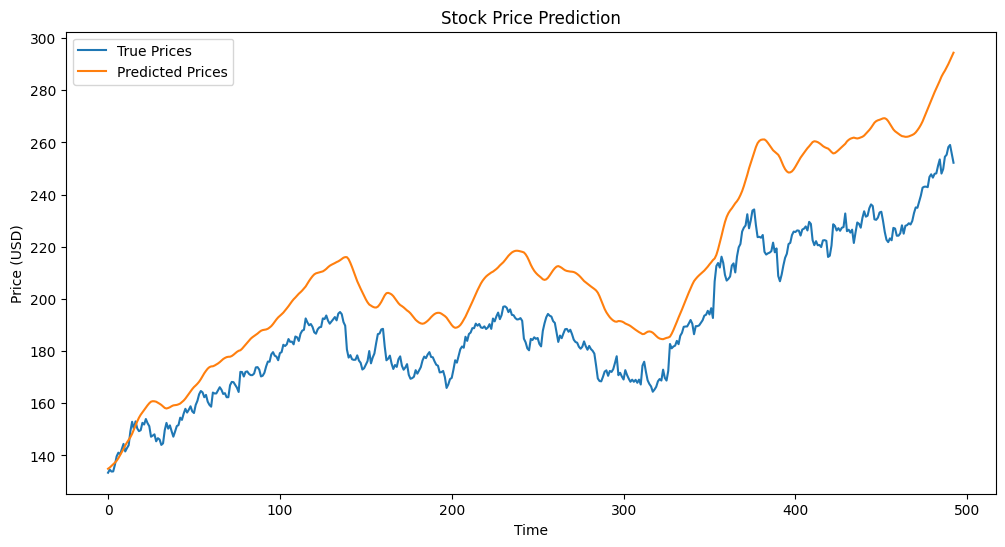

In [19]:
# Step 10: Plot the results
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="True Prices")
plt.plot(predictions, label="Predicted Prices")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()